In [2]:
import os
import cv2
import tensorflow as tf # TensorFlow
import numpy as np
import matplotlib.pyplot as plt
import glob
from skimage import data,io
from skimage.color import *
from skimage import io, transform, img_as_float, filters
import imageio
from tqdm import tqdm

## Part1: preprocessing of video: Extracting frames and generate the dataset of AutoEncoder (Not necessary to run this part, because we have packed the all necessary data in our work.)

In [ ]:
# extract all frames into the file: "./all_frames"
def extract_frames(video_path):
  if not os.path.exists("./all_frames"):
    os.mkdir("./all_frames")

  vc=cv2.VideoCapture(video_path)
  if vc.isOpened():
    rval,frame=vc.read()
  else:
    rval=False
    print("Can not open the video")
  c=0
  i=0
  while rval:
  
    rval, frame = vc.read()
    
    frame=frame[150:-150,:] # remove the black bound and film subtitling
    
    frame=cv2.resize(frame,(800,400))
    if c %5==0:
        cv2.imwrite(filename="./all_frames/frame_"+str(i)+".jpg",img=frame)
        i+=1
    c += 1

In [ ]:
## Extract frames into file "all_frames"
extract_frames("1917.mp4")

In [ ]:
def get_AE_dataset(path):
  os.chdir("/content/drive/My Drive")
  if os.path.exists(path):
    dataset=np.load(path)
    dataset=dataset/255.0
    print(dataset.shape)
  else:
    all_images_path=list(glob.glob("./all_frames/*"))
    all_images_path.sort() 
    dataset=[]
    for path in all_images_path:
      image = io.imread(path)  # 读取图片      
      image = tf.image.resize(image, [256, 512])  # 原始图片大小为(400, 800, 3)，重设为(256, 512)
      image /= 255.0  # 归一化到[0,1]范围S
      dataset.append(image)
    dataset=np.array(dataset)
    np.save("dataset.npy",dataset)
    print(dataset.shape)
  return dataset  
      

Generate the AutoEncoder model:  
we set latent dimension to 256  


In [ ]:
latent_dims=256

# Encoder
input_image = tf.keras.layers.Input(shape=(256,512,3))
x = tf.keras.layers.Conv2D(64, (7,7),padding='valid', activation='relu')(input_image)

x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x) 
x =  tf.keras.layers.Conv2D(64, (3,3),padding='valid', activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x =  tf.keras.layers.Conv2D(64, (3,3),padding='valid', activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x =  tf.keras.layers.Conv2D(64, (3,3),padding='valid', activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x =  tf.keras.layers.Conv2D(64, (3,3),padding='valid', activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Flatten()(x)
encoded_input = tf.keras.layers.Dense(latent_dims, activation='relu')(x)


# Decoder
x = tf.keras.layers.Reshape((8,16,2))(encoded_input)  
x =  tf.keras.layers.UpSampling2D((2, 2))(x)  


x = tf.keras.layers.Conv2DTranspose(64, (3,3),padding='same', activation='tanh')(x)

x =  tf.keras.layers.UpSampling2D((2, 2))(x)


x = tf.keras.layers.Conv2DTranspose(64, (3,3), padding='same', activation='tanh')(x)


x =  tf.keras.layers.UpSampling2D((2, 2))(x)

x = tf.keras.layers.Conv2DTranspose(64, (3,3), padding='same', activation='tanh')(x)
x =  tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2DTranspose(64, (3,3), padding='same', activation='tanh')(x)
x =  tf.keras.layers.UpSampling2D((2, 2))(x)

decoded_output =tf.keras.layers.Conv2D(3, (3,3),padding='same', activation='sigmoid')(x)

autoencoder = tf.keras.models.Model(input_image, decoded_output)

# autoencoder.compile(optimizer = 'adam', loss = 'binary_crossentropy') # MSE 


Get Training model and train it

In [ ]:
X_train=get_AE_dataset("dataset.npy")



(1194, 256, 512, 3)


In [ ]:
autoencoder.load_weights('./model_save/autoencoder_rgb_256.h5')
autoencoder.compile(optimizer = 'adam', loss = 'binary_crossentropy') # MSE 

In [ ]:
history = autoencoder.fit(X_train,X_train,epochs =100,batch_size =50, shuffle = True)
autoencoder.save("./model_save/autoencoder_rgb_256.h5")
encoder = tf.keras.models.Model(input_image, encoded_input, name='encoder')
encoder.save("./model_save/encoder_rgb_256.h5")

Epoch 1/100
24/24 [==============================] - 11s 478ms/step - loss: 0.6785
Epoch 2/100
24/24 [==============================] - 10s 406ms/step - loss: 0.6469
Epoch 3/100
24/24 [==============================] - 10s 409ms/step - loss: 0.6420
Epoch 4/100
24/24 [==============================] - 10s 410ms/step - loss: 0.6405
Epoch 5/100
24/24 [==============================] - 10s 404ms/step - loss: 0.6390
Epoch 6/100
24/24 [==============================] - 10s 409ms/step - loss: 0.6378
Epoch 7/100
24/24 [==============================] - 10s 408ms/step - loss: 0.6373
Epoch 8/100
24/24 [==============================] - 10s 410ms/step - loss: 0.6370
Epoch 9/100
24/24 [==============================] - 10s 412ms/step - loss: 0.6369
Epoch 10/100
24/24 [==============================] - 10s 408ms/step - loss: 0.6367
Epoch 11/100
24/24 [==============================] - 10s 409ms/step - loss: 0.6366
Epoch 12/100
24/24 [==============================] - 10s 412ms/step - loss: 0.6366
E

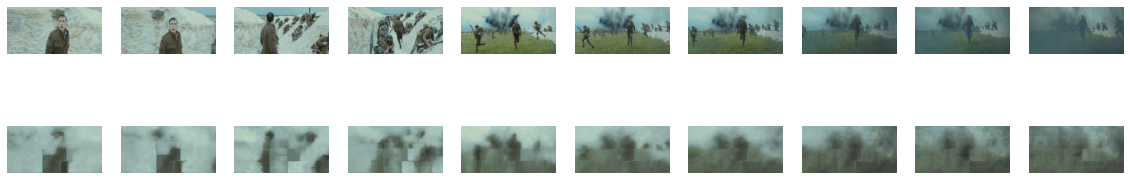

In [ ]:
def plot_contrast(autoencoder,X_train):
  reconstructed_img = autoencoder.predict(X_train[:10])

  plt.figure(figsize=(20, 4))
  for i in range(10):
      # display original
      ax = plt.subplot(2, 10, i + 1)
      plt.imshow(X_train[i])
      plt.axis('off')
      
      # display reconstructed images
      ax = plt.subplot(2, 10, i + 1 + 10)
      plt.imshow(reconstructed_img[i])
      plt.axis('off')
  plt.show()
plot_contrast(autoencoder,X_train)

## Part2: Extract features of images and get pretrained encoder

In [18]:
def get_dataset(frame_path):
  print("Loading image dataset....")
  all_images_path=list(glob.glob(frame_path+"/*"))
  all_images_path.sort() 
  dataset=[]
  for path in tqdm(all_images_path):
    image = io.imread(path)    
    image = tf.image.resize(image,[256, 512])
    image /= 255.0  
    dataset.append(image)
  dataset=tf.convert_to_tensor(dataset)
  dataset=dataset.numpy()
  print(dataset.shape)
  return dataset



def extract_features(dataset,model_path):
  
  data=dataset
  print("Loading pretrained model")
  net = tf.keras.models.load_model(model_path,compile=False) #load model
  dataSet = net.predict(data)
  print("Finished and the shape fo dataset is:")
  print(dataSet.shape)
  return dataSet

##Part3: Clustering

In [22]:

#Initialize center: randamly pick k centers
def clusterAssignment(dataSet,k=10,iter=40):
  def initCenters(dataSet,k):
    numSamples,dim=dataSet.shape
    centers=np.zeros((k,dim))
    for i in range(k):
        index=int(np.random.uniform(0,numSamples)) # random get k centers
        centers[i,:]=dataSet[index,:]
    
    return centers

  #Dist2Centers: calculate the distance between center and data
  def Dist2Centers(sample,centers):
    k=centers.shape[0]
    dis2cents=np.zeros(k)
    for i in range(k):
        dis2cents[i]=np.sqrt(np.sum(np.power(sample-centers[i,:],2))).astype("float32")
    return dis2cents

  #kmeans
  def kmeans(dataSet,k,iterNum):
    numSamples=dataSet.shape[0]
    iterCount=0

    #clusterAssignment stores which cluster this sample belongs to
    clusterAssignment=np.zeros(numSamples)
    clusterChanged=True

    ##step 1: initialize centers
    centers=initCenters(dataSet,k)
    while clusterChanged and iterCount <iterNum:
        clusterChanged=False
        iterCount=iterCount+1

        # for each sample
        for i in range(numSamples):
            dis2cent=Dist2Centers(dataSet[i,:],centers)
            minIndex=np.argmin(dis2cent) #return the minmum index of argmin

            ## step 3: update its belonged cluster
            if clusterAssignment[i] !=minIndex:
                clusterChanged=True
                clusterAssignment[i]=minIndex

        ## step 4: update centers
        for j in range(k):
            pointsInCluster=dataSet[np.nonzero(clusterAssignment[:]==j)[0]]
            centers[j,:]=np.mean(pointsInCluster,axis=0) 
    print("Cluster Achieved !")
    return centers,clusterAssignment


  ## step 1: load dataset
  print("step 1: loading dataset...")
  dataSet=dataSet

  ## step 2: clustering...
  print("step 2: clustering...")
  dataSet=np.mat(dataSet)
  k=k
  centers_result,clusterAssignment_result=kmeans(dataSet,k,iter)
  return centers_result,clusterAssignment_result

  
# collect 10 classes
def collect(clusterAssignment_result):
  x1=[];x2=[];x3=[];x4=[];x5=[];x6=[];x7=[];x8=[];x9=[];x10=[]

  for i in range(len(clusterAssignment_result)):
    if clusterAssignment_result[i]==0:
      x1.append(i)
    elif clusterAssignment_result[i]==1:
      x2.append(i)
    elif clusterAssignment_result[i]==2:
      x3.append(i)
    elif clusterAssignment_result[i]==3:
      x4.append(i)
    elif clusterAssignment_result[i]==4:
      x5.append(i)
    elif clusterAssignment_result[i]==5:
      x6.append(i)  
    elif clusterAssignment_result[i]==6:
      x7.append(i)
    elif clusterAssignment_result[i]==7: 
      x8.append(i) 
    elif clusterAssignment_result[i]==8: 
      x9.append(i)
    else:  
      x10.append(i)  
  return x1,x2,x3,x4,x5,x6,x7,x8,x9,x10

def extract(clusterAssignment_result,centers_result,dataSet):
  x1,x2,x3,x4,x5,x6,x7,x8,x9,x10=collect(clusterAssignment_result)
  x=[]
  dis1 = np.zeros(len(x1))
  for j in range(len(x1)):   
    dis1[j] = np.sqrt(np.sum(np.power(dataSet[x1[j],:]-centers_result[0,:],2))).astype("float32")
  idx=np.argmin(dis1)
  x.append(x1[idx])

  dis2 = np.zeros(len(x2))
  for j in range(len(x2)):  
    dis2[j] = np.sqrt(np.sum(np.power(dataSet[x2[j],:]-centers_result[1,:],2))).astype("float32")
  idx=np.argmin(dis2)
  x.append(x2[idx])

  dis3 = np.zeros(len(x3))
  for j in range(len(x3)):  
    dis3[j] = np.sqrt(np.sum(np.power(dataSet[x3[j],:]-centers_result[2,:],2))).astype("float32")
  idx=np.argmin(dis3)
  x.append(x3[idx])

  dis4 = np.zeros(len(x4))
  for j in range(len(x4)):  
    dis4[j] = np.sqrt(np.sum(np.power(dataSet[x4[j],:]-centers_result[3,:],2))).astype("float32")
  idx=np.argmin(dis4)
  x.append(x4[idx])

  dis5 = np.zeros(len(x5))
  for j in range(len(x5)):  
    dis5[j] = np.sqrt(np.sum(np.power(dataSet[x5[j],:]-centers_result[4,:],2))).astype("float32")
  idx=np.argmin(dis5)
  x.append(x5[idx])

  dis6 = np.zeros(len(x6))
  for j in range(len(x6)):  
    dis6[j] = np.sqrt(np.sum(np.power(dataSet[x6[j],:]-centers_result[5,:],2))).astype("float32")
  idx=np.argmin(dis6)
  x.append(x6[idx])

  dis7 = np.zeros(len(x7))
  for j in range(len(x7)):  
    dis7[j] = np.sqrt(np.sum(np.power(dataSet[x7[j],:]-centers_result[6,:],2))).astype("float32")
  idx=np.argmin(dis7)
  x.append(x7[idx])

  dis8 = np.zeros(len(x8))
  for j in range(len(x8)):  
    dis8[j] = np.sqrt(np.sum(np.power(dataSet[x8[j],:]-centers_result[7,:],2))).astype("float32")
  idx=np.argmin(dis8)
  x.append(x8[idx])

  dis9 = np.zeros(len(x9))
  for j in range(len(x9)):  
    dis9[j] = np.sqrt(np.sum(np.power(dataSet[x9[j],:]-centers_result[8,:],2))).astype("float32")
  idx=np.argmin(dis9)
  x.append(x9[idx])

  dis10 = np.zeros(len(x10))
  for j in range(len(x10)):  
    dis10[j] = np.sqrt(np.sum(np.power(dataSet[x10[j],:]-centers_result[9,:],2))).astype("float32")
  idx=np.argmin(dis10)
  x.append(x10[idx])
  print(x)

  return x

## Part4: GetCoolSummary and GIF

In [13]:
def merge_pixel(imgf1, imgf2, alpha=1, axis='ver'):
    start_alpha = alpha
    height, width, channels = imgf1.shape
    r_imgf = np.zeros((height, width, channels))
    # assuming the height and width are even
    if axis is 'ver':
        decay = np.linspace(alpha, 0, height)
        for i in range(height):
            r_imgf[i,:,:] = decay[i]*imgf1[i,:,:] + (1-decay[i])*imgf2[i,:,:]
            
    else:
        decay = np.linspace(alpha, 0, width)
        for j in range(width):
            r_imgf[:,j,:] = decay[j]*imgf1[:,j,:] + (1-decay[j])*imgf2[:,j,:]
        
    return r_imgf
    

# concatenate two images with novlap width overlapped horizontally
def concatImg_hor(img1, img2, novlap=100, alpha=1):
    height, width, channels = img1.shape
    mimg1 = img1[:,0:width-novlap,:]
    mimg2 = img2[:,novlap:,:]
    oimg1 = img1[:,width-novlap:,:]
    oimg2 = img2[:,0:novlap,:]
    oimg = merge_pixel(oimg1, oimg2, alpha=alpha, axis='hor')
    # oimg_temp = np.hstack((mimg1[:,-10:,:], ))
    # oimg = filters.gaussian(oimg, sigma=5)
    tempimg = np.hstack((mimg1, oimg))
    tempimg = np.hstack((tempimg, mimg2))
#     r_height, r_width, r_channels = tempimg.shape
#     img_range = (int(np.floor(r_width/2))-novlap, int(np.ceil(r_width/2))+novlap)
#     blurimg = tempimg[:,img_range[0]:img_range[1],:]
#     blurimg = filters.gaussian(blurimg, sigma=10)
#     tempimg[:,img_range[0]:img_range[1],:] = blurimg
    return tempimg

# concatenate two images with novlap height overlapped vertically
def concatImg_ver(img1, img2, novlap=80, alpha=1):
    height, width, channels = img1.shape
    mimg1 = img1[:height-novlap,:,:]
    mimg2 = img2[novlap:,:,:]
    oimg1 = img1[height-novlap:,:,:]
    oimg2 = img2[0:novlap,:,:]
    oimg = merge_pixel(oimg1, oimg2, alpha=alpha, axis='ver')
    tempimg = np.vstack((mimg1,oimg))
    tempimg = np.vstack((tempimg, mimg2))
#     r_height, r_width, r_channels = tempimg.shape
#     img_range = (int(np.floor(r_height/2))-novlap, int(np.ceil(r_height/2))+novlap)
#     blurimg = tempimg[img_range[0]:img_range[1],:,:]
#     blurimg = filters.gaussian(blurimg, sigma=10)
#     tempimg[img_range[0]:img_range[1],:,:] = blurimg
    return tempimg

def generateCoolSummary_10(image_list):
    for i in range(len(image_list)):
        image_list[i] = img_as_float(image_list[i])
    assert(len(image_list) == 10)
    part1 = concatImg_hor(image_list[0], image_list[1])
    part1 = concatImg_hor(part1, image_list[2])
    part2 = concatImg_hor(image_list[3], image_list[4])
    temp = concatImg_hor(image_list[5], image_list[6])
    part2 = concatImg_ver(part2, temp)
    part3 = concatImg_hor(image_list[7], image_list[8])
    part3 = concatImg_hor(part3, image_list[9])
    
    p2_height, p2_width, p2_channels = part2.shape
    p3_height, p3_width, p3_channels = part3.shape
    part2 = transform.resize(part2, (int(p3_width/p2_width*p2_height),p3_width))
    result = concatImg_ver(part1, part2)
    result = concatImg_ver(result, part3)
    return result
def create_gif(image_list, save_name, duration=0.1):
    # Save them as datasets into a gif
    imageio.mimsave(save_name, image_list, 'GIF', duration=duration)
    return

In [24]:
def get_image_list(image_idx,path):
  image_list=[]
  for i in image_idx:
    image_name=path+"/frame_"+str(i)+".jpg"
    image=io.imread(image_name)
    image_list.append(image)
  return image_list

In [25]:
def generateCoolSummary(path):
  print("Step 1: Extract image features...")
  dataset=get_dataset(path)
  modelpath="./model_save/encoder_rgb_256.h5"
  feature_set=extract_features(dataset,modelpath)
  print("Step 2: Clustering...........")
  centers_result,clusterAssignment_result=clusterAssignment(feature_set,k=10,iter=40)
  image_idx=extract(clusterAssignment_result,centers_result,feature_set)
  image_list=get_image_list(image_idx,path)
  print("Step 3: Get Cool Summary.....")
  r_img = generateCoolSummary_10(image_list)
  io.imshow(r_img)
  io.imsave('Cool_summary.jpg',r_img)
  save_name="Cool_summary.gif"
  print("Step 4: Generate the GIF.......")
  create_gif(image_list, save_name, duration=0.3)
  print("Finished")


  1%|          | 9/1194 [00:00<00:13, 87.72it/s]

Step 1: Extract image features...
Loading image dataset....



100%|██████████| 1194/1194 [00:14<00:00, 79.68it/s]


(1194, 256, 512, 3)
Loading pretrained model
Finished and the shape fo dataset is:
(1194, 256)
Step 2: Clustering...........
step 1: loading dataset...
step 2: clustering...
Cluster Achieved !
[910, 650, 216, 1127, 389, 104, 485, 399, 13, 823]
Step 3: Get Cool Summary.....


Step 4: Generate the GIF.......


Finished


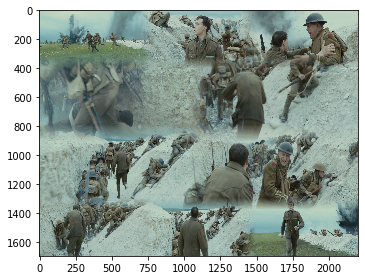

In [26]:
path="./all_frames"
os.chdir("/content/drive/My Drive")
generateCoolSummary(path)